# MIT COVID-19 Datathon

## Research Question: 
#### How did U.S. state-level shelter-in-place orders impact the proportion of COVID-19 positive cases (among those tested) and does this impact differ by socioeconomic status?

In [0]:
# import requirements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statistics as stat
from pylab import rcParams

In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/smruthiramesh/MIT_COVID-19_Datathon/master/ny_county_data/ny_county_data.csv")

## Basic Processing and Exploration

In [0]:
#dropping extra column
df.drop("Unnamed: 0",axis=1,inplace=True)

In [65]:
df.head()

,FIPS,Median_Household_Income_2018,transit_scores,Test Date,New Positives,Cumulative Number of Positives,Total Number of Tests Performed,Cumulative Number of Tests Performed
0,36001,64536.0,7.100041e+09,05/13/2020,15.0,1509.0,546.0,15792.0
1,36001,64536.0,7.100041e+09,05/12/2020,15.0,1494.0,335.0,15246.0
2,36001,64536.0,7.100041e+09,05/11/2020,23.0,1479.0,341.0,14911.0
3,36001,64536.0,7.100041e+09,05/10/2020,24.0,1456.0,384.0,14570.0
4,36001,64536.0,7.100041e+09,05/09/2020,16.0,1432.0,455.0,14186.0


In [0]:
#code to exclude days with zero tests
# df = df[df['Total Number of Tests Performed']!=0.0]

In [70]:
print("Proportion of test data that is zero positive cases: ",df[df['New Positives']==0.0].shape[0]/df.shape[0])

Proportion of test data that is zero positive cases:  0.296220633299285


## Feature Creation

### Bucketing Household Income

We will use 25th and 75th percentile of the income data to denote low-income and high-income counties.

In [0]:
#setting percentile cutoffs
low_percentile = np.percentile(df['Median_Household_Income_2018'],25)
high_percentile = np.percentile(df['Median_Household_Income_2018'],75)

In [0]:
#creating column with bucketed income values
col         = 'Median_Household_Income_2018'
conditions  = [ df[col] > high_percentile, (df[col] <= high_percentile) & (df[col]> low_percentile), df[col] <= low_percentile ]
choices     = [ 3, 2, 1 ]
df['Income_Ctg'] = np.select(conditions, choices, default=np.nan)
df['Income_Ctg'] = df['Income_Ctg'].apply(lambda x: int(x))

### Outcome Variable

We use the natural log difference of cumulative cases as our outcome variable.
(citation)

In [69]:
#calculating natural log diff of cumulative positives and replacing first entry with zero
df['NatLogDiff'] = np.append([0],np.array(df['Cumulative Number of Positives'].apply(np.log).diff())[1:])

/usr/local/lib/python3.6/dist-packages/pandas/core/algorithms.py:1926: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


### Trend variables

"Pre-implementation (14 days prior, through three days after, implementation of the first statewide social distancing measure) versus post-implementation (four or more days after implementation). We selected this transition point based on estimates of the COVID-19 incubation period". https://www.medrxiv.org/content/10.1101/2020.04.03.20052373v2.full.pdf 

Our definition:
pre-pause dates: 14 days prior, through three days after, March 22, 2020 
March 8, 2020 - March 25, 2020 (including March 25)

post-pause dates: 4 or more days after March 22, 2020
March 26, 2020 - most current date


#### Binary variable to indicate pre and post intervention

In [0]:
#sorting data by date
df = df.sort_values('Test Date')

#converting type to datetime for comparisons
df['dt_test_date'] = pd.to_datetime(df['Test Date'])

#Creating new binary intervention variable for "New York State on PAUSE"
df['After Order'] = np.where(df['dt_test_date'].apply(lambda x: x>= pd.to_datetime('03/26/2020').date()), 1, 0)

#### Pre-pause time trend variable

We assign a number to each unique date in ascending order, starting with 1. This variable will be our pre-pause trend variable.

In [0]:
#total list of unique dates in df
total_range = df['Test Date'].unique()

dates_total = [str(x).split()[0] for x in total_range]
date_numbers = list(range(1,len(dates_total)+1))
mapping_dict = dict(list(zip(dates_total, date_numbers)))

#creating pre trend column
df['Pre Trend'] = df['Test Date'].apply(lambda x: mapping_dict[x])

### Visualization of log-outcome over time with markers 

Create a time series graph for log-outcome over time and mark the implementation date of NY State on PAUSE: March 22, 2020 and also mark 4 days after this, March 26, 2020

In [0]:
#outcome is a mean over all counties for each test date 
grouped_df = df.groupby('Test Date')['NatLogDiff'].mean().reset_index()

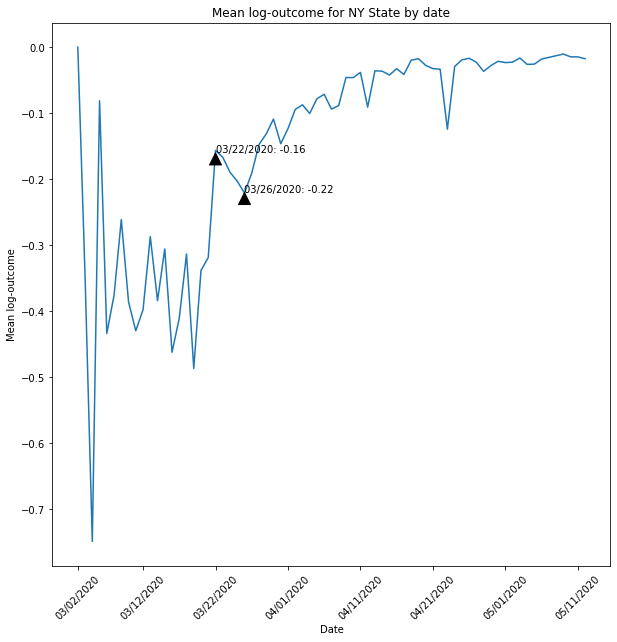

In [115]:
#date ranges for testing data (used for setting x ticks in plotting)
ranges = pd.date_range(min(grouped_df['Test Date']),max(grouped_df['Test Date']), freq='10D')
plot_dates = [str(x).split()[0] for x in ranges.strftime('%m/%d/%Y')]

#outcome values at marker dates
o1= round(float(grouped_df[grouped_df['Test Date']=='03/22/2020']['NatLogDiff']),2)
o2 = round(float(grouped_df[grouped_df['Test Date']=='03/26/2020']['NatLogDiff']),2)

fig = plt.figure()
ax = fig.add_subplot(111)

#Creating time series graph
plt.plot(grouped_df['Test Date'], grouped_df['NatLogDiff'])
plt.xticks(plot_dates)
plt.xticks(rotation=45)

#creating markers
A = '03/22/2020','03/26/2020'
B = o1,o2
for xy in zip(A, B):
  ax.annotate('%s: %s' % xy, xy=xy, textcoords='data',arrowprops=dict(facecolor='black', shrink=0.05))

rcParams['figure.figsize'] = 10,10

plt.title("Mean log-outcome for NY State by date")
plt.xlabel("Date")
plt.ylabel("Mean log-outcome");

## Proportion analysis - could keep in for EDA

In [0]:
df['proportion_cases'] = df['New Positives']/df['Total Number of Tests Performed']

On average, there was a daily COVID-19 positive rate of  ~17% in NY State. 
We will test if this changed over time and if it changed before and after "New York State on PAUSE" executive order on March 22, 2020. 

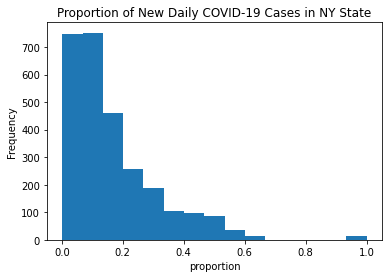

In [77]:
#histogram of outcome variable
plt.hist(df["proportion_cases"], bins = 15)
plt.xlabel("proportion")
plt.ylabel("Frequency")
plt.title("Proportion of New Daily COVID-19 Cases in NY State");

Outcome is right-skewed; looks like majority of proportions are between 0.0-0.12 (0-12% daily new cases in the state)

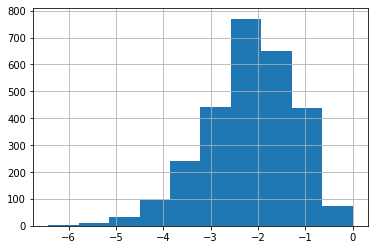

In [78]:
#log transform outcome 
df["proportion_cases"].apply(np.log).hist()
plt.show()

In [0]:
#creating a new column of log transformed values
df['log_proportion'] = df["proportion_cases"].apply(np.log)

#### Post-trend Variable - NOT USED CURRENTLY 

Creating another time variable to look at post-trend sustained effects.

Any date prior to March 26, 2020 gets a 0, and any dates on or after March 26, 2020 gets assigned a number in ascending order, starting with 1

In [0]:
#Creating new time variable for post-pause trend

post_range = df[df['After Order']==1]['Test Date'].unique()

#setting post trend values for dates from March 26 onwards
dates_post = [str(x).split()[0] for x in post_range]
post_numbers = list(range(1,len(dates_post)+1))
mapping_dict_post = dict(list(zip(dates_post, post_numbers)))

#setting post trend values for dates before March 26 
dates_pre = [x for x in total_range if x not in post_range]
pre_numbers = [0]*len(dates_pre)
mapping_dict_post.update(dict(list(zip(dates_pre, pre_numbers))))

#creating post trend column
df['Post Trend'] = df['Test Date'].apply(lambda x: mapping_dict_post[x])

## Code to save data if necessary

In [0]:
#code to save data

# from google.colab import drive
# drive.mount('drive')
# df.to_csv('data.csv')
# !cp data.csv "drive/My Drive/"

## Modeling

Create ITS mixed effects linear regression model

y = log proportion of new positive COVID-19 cases

x = post_pause (the binary intervention variable)

Other independent variables in model: pre-pause time, interaction term between pre-pause time and post_pause, post_trend

Include County random effect

If interaction term is statistically significant, then the intervention had an effect on the proportion of new COVID-19 cases

Work on including the income and maybe transit variable into the model afterwards


In [0]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [0]:
df["Pre_Trend"] = df["Pre Trend"]
# df["Post_Trend"] = df["Post Trend"]
df["After_Order"] = df["After Order"]

In [122]:
df["Interaction_Term"] = df["After_Order"] * df["Pre_Trend"]
df.tail()

,FIPS,Median_Household_Income_2018,transit_scores,Test Date,New Positives,Cumulative Number of Positives,Total Number of Tests Performed,Cumulative Number of Tests Performed,Income_Ctg,NatLogDiff,proportion cases,proportion_cases,log_proportion,dt_test_date,After Order,Pre Trend,Pre_Trend,After_Order,Interaction_Term
2920,36081,68432.0,NaN,05/13/2020,336.0,58084.0,4439.0,171836.0,3,inf,0.075693,0.075693,-2.581073,2020-05-13,1,72,72,1,72
4162,36115,55913.0,2.108902e+09,05/13/2020,1.0,215.0,77.0,1775.0,2,inf,0.012987,0.012987,-4.343805,2020-05-13,1,72,72,1,72
3139,36087,88960.0,2.227306e+09,05/13/2020,53.0,12596.0,1096.0,39615.0,3,inf,0.048358,0.048358,-3.029131,2020-05-13,1,72,72,1,72
4235,36117,61118.0,3.680914e+08,05/13/2020,5.0,89.0,120.0,2447.0,2,inf,0.041667,0.041667,-3.178054,2020-05-13,1,72,72,1,72
0,36001,64536.0,7.100041e+09,05/13/2020,15.0,1509.0,546.0,15792.0,3,0.0,0.027473,0.027473,-3.594569,2020-05-13,1,72,72,1,72


In [0]:
def run_model(df):
  md = smf.mixedlm("NatLogDiff  ~ After_Order + Pre_Trend + Interaction_Term", df, groups=df["FIPS"])
  mdf = md.fit()
  print(mdf.summary())


for i in range(3):
  model_df = df.loc[df['Income_Ctg'] == i+1]
  run_model(model_df)

In [0]:
import numpy as np
def get_outcome(df):
  outcome = []
  for i in df['dt_test_date'].unique():
    temp_df = df.loc[df['dt_test_date'] == i]
    outcome.append(np.mean(temp_df["NatLogDiff"]))
  return outcome


temp_df1 = df.loc[df['Income_Ctg'] == 1]
outcome1 = get_outcome(temp_df1)
print(outcome1)
temp_df2 = df.loc[df['Income_Ctg'] == 2]
outcome2 = get_outcome(temp_df2)
print(outcome2)
temp_df3 = df.loc[df['Income_Ctg'] == 3]
outcome3 = get_outcome(temp_df3)
print(outcome3)
print(len(outcome1), len(outcome2), len(outcome3), len(df['dt_test_date'].unique()))

plt.bar(temp_df1['dt_test_date'].unique(), outcome1, color='b', alpha=0.9, label='low income')
plt.bar(temp_df2['dt_test_date'].unique(), outcome2, color='r', alpha=0.9, label='med income')
plt.bar(temp_df3['dt_test_date'].unique(), outcome3, color='g', alpha=0.9, label='high income')
plt.legend()
plt.ylim([0,2])
plt.ylabel('Natural Log Difference in Cases Relative to Previous Day')
plt.xlabel('Date')

In [0]:
import matplotlib.pyplot as plt
trimmed_df = df.loc[df['dt_test_date'] == '2020-04-09']
print(len(trimmed_df))
trimmed_df = trimmed_df.sort_values(by=['Median_Household_Income_2018'])
trimmed_df.plot(kind='bar',x='Median_Household_Income_2018',y='Cumulative Number of Positives',color='red')
# plt.plot(trimmed_df["Median_Household_Income_2018"], trimmed_df["Cumulative Number of Positives"])

In [0]:
#try re-doing time series graph after restricting to highest density counties


In [0]:
df.head()

In [0]:
#descriptive stats of new outcome 
df[['NatLogDiff']].describe()

In [0]:
#histogram
plt.hist(df["NatLogDiff"])

In [0]:
#mean of new outcome stratified by income categories
average_outcome_income = df.groupby(['income var'])['outcome'].mean()